<a href="https://colab.research.google.com/github/AleksandraJuras2000/Kurs_Udemi_nn/blob/main/04_klasyfikacja/Sieci_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import Sequence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil     #kopiowanie plików czy cos w tym stylu
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

In [ ]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip

--2025-02-21 12:13:53--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.179.207, 142.251.184.207, 209.85.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.179.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  31.9MB/s    in 47s     

2025-02-21 12:14:41 (31.1 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [ ]:
!unzip -q flying-vehicles.zip

In [ ]:
!rm -rf ./images

In [ ]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [ ]:
data_dir = './images'

In [ ]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [ ]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]  # wybieramy tylko te które mają te rozszerzenia
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [ ]:
size = min(len(drone_fnames), len(passenger_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [ ]:
valid_idx

1180

In [ ]:
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


(-0.5, 767.5, 512.5, -0.5)

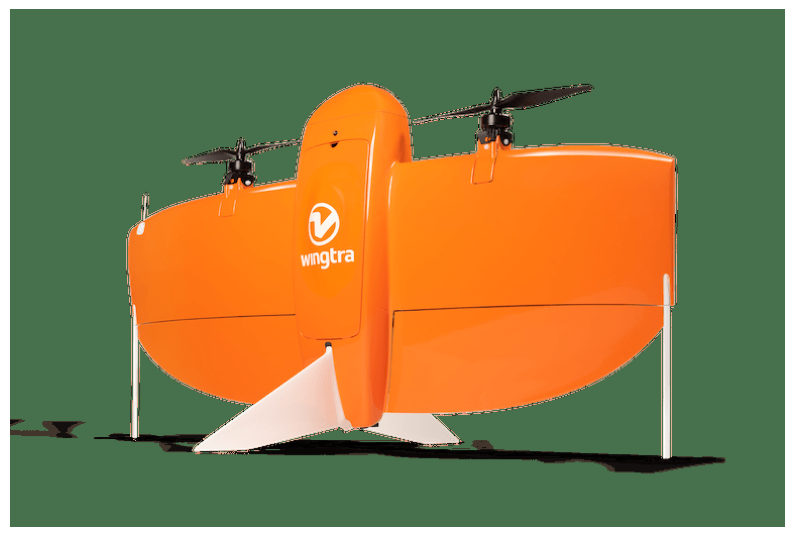

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 632 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 699.5, 699.5, -0.5)

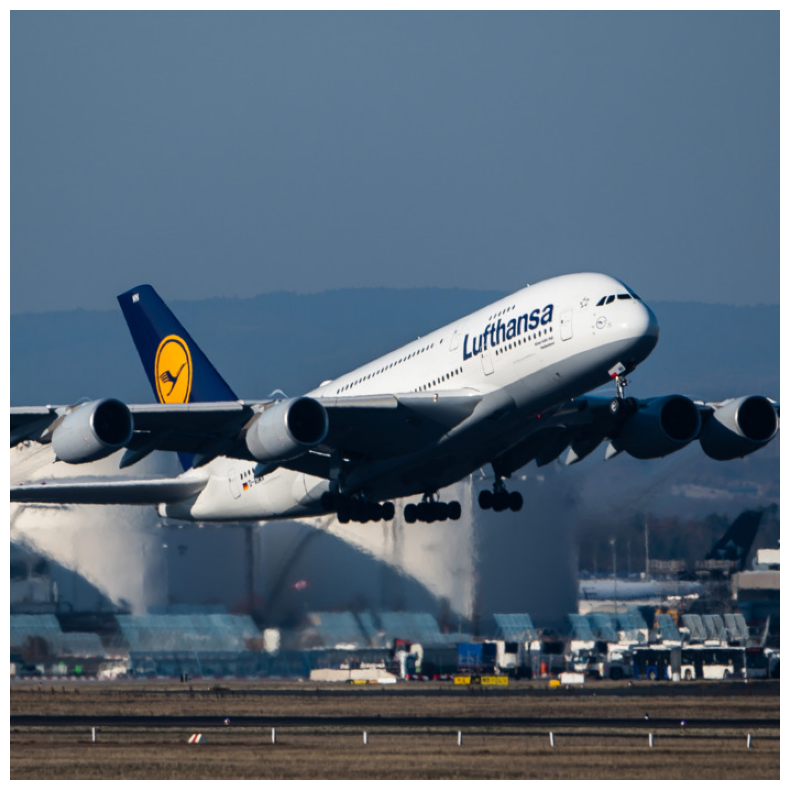

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 697 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## Augmentacja Danych

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),   # standaryzacja ustalenie wielkości zdjęcia
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [ ]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

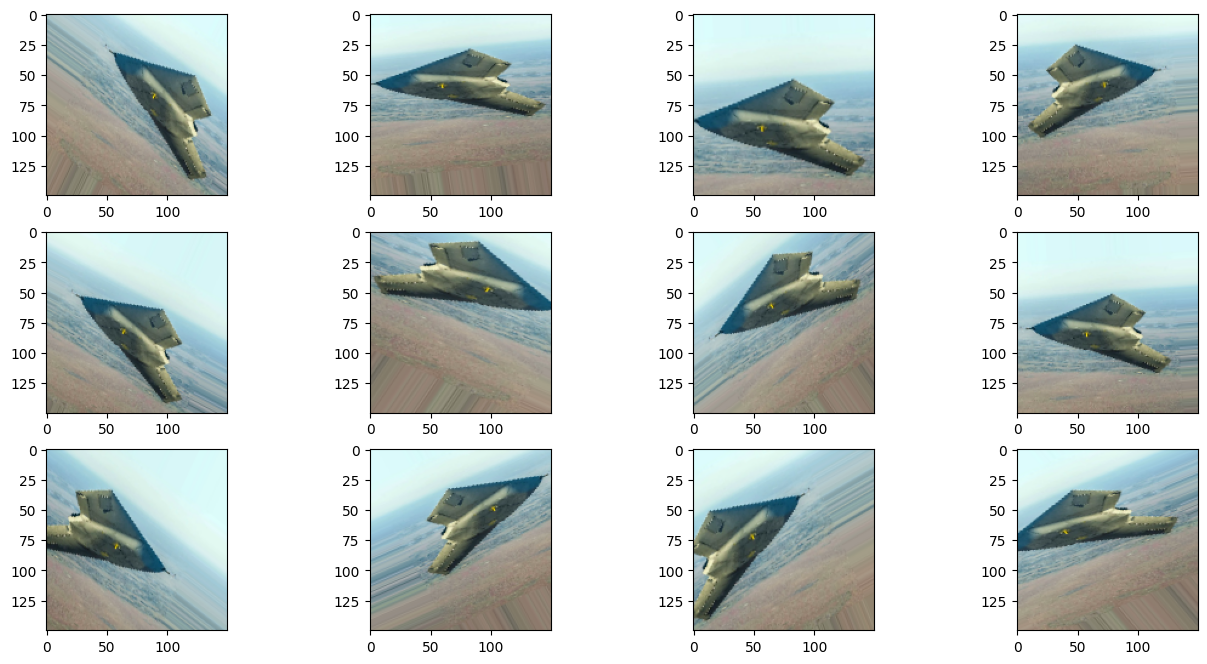

In [ ]:
#@title Zbiór treningowy drone:
idx = 690 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

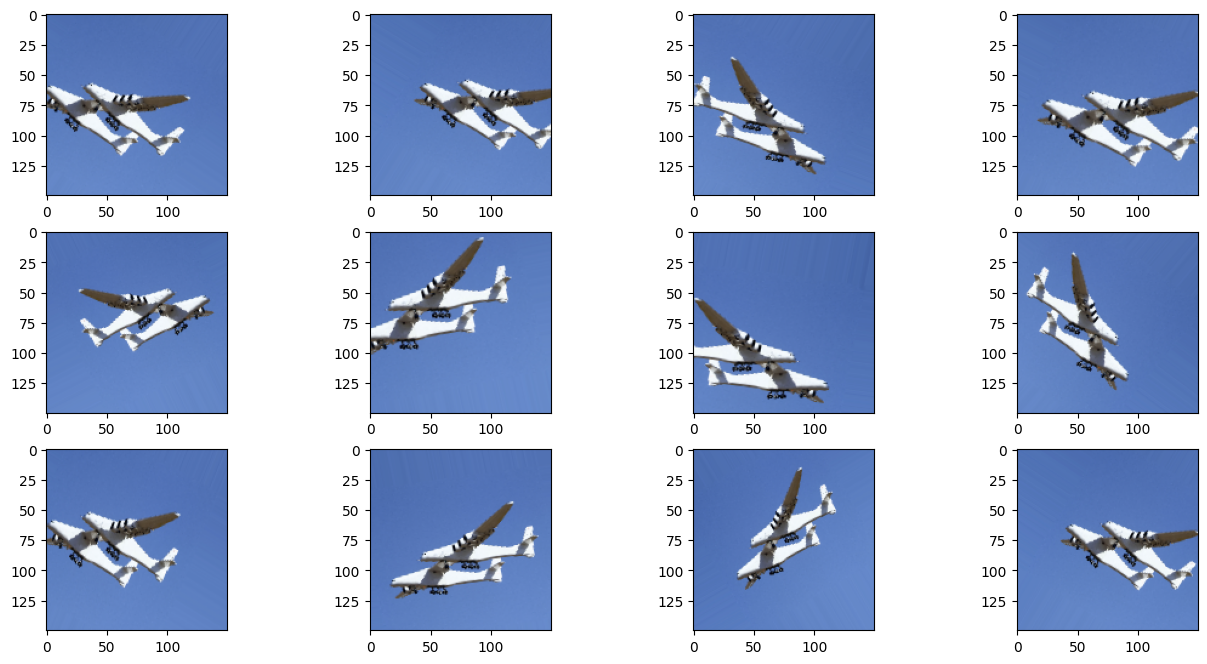

In [ ]:
idx = 157 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

## BUDOWA MODELU
Sieć konwolucyjna służy do redukcji wymiarowości i rozpoznawania przestrzennych cech z naszych zdjęc

In [ ]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))   # operacja splotu, filtry i redukcja zdjęć, to ile filtróow zastrosujemy zalezy tylko od nas zazwyczaj jest to potęga 2
model.add(layers.MaxPooling2D(pool_size=(2, 2)))    # okienko które nam lata po obrazie rozmiaru dwwa na dwa i wyciąga największ a wartość pixela
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))  # tu zazwyczaj zwiększa sie ilość filtrów
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')) # jeszcze więcej filtrów
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())   # teraz dopiero nasze dane zostają wypłaszczone
model.add(layers.Dense(units=512, activation='relu')) # teraz wartstwa gęsto połączona
model.add(layers.Dense(units=1, activation='sigmoid')) # na koniec tylko jeden neuron bo kotegoria binarna i activation sigmoid
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [ ]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit(train_generator,         # dane generowane w locie!
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,    # 100
                    validation_data=valid_generator,
                    validation_steps=validation_steps,
                    callbacks=[tensorboard])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4846 - loss: 0.7003 - val_accuracy: 0.5117 - val_loss: 0.6925
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5571 - loss: 0.6849 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 3/30
 2/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6719 - loss: 0.6818

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6283 - loss: 0.6850 - val_accuracy: 0.4844 - val_loss: 0.6987
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5266 - loss: 0.6944 - val_accuracy: 0.4727 - val_loss: 0.6953
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5501 - loss: 0.6877 - val_accuracy: 0.5117 - val_loss: 0.6906
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.5452 - loss: 0.6856 - val_accuracy: 0.5898 - val_loss: 0.6827
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5734 - loss: 0.6831 - val_accuracy: 0.6094 - val_loss: 0.6778
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5779 - loss: 0.6798 - val_accuracy: 0.5664 - val_loss: 0.6765
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.6401 - loss: 0.6753 - val_accuracy: 0.5547 - val_loss: 0.6755
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5942 - loss: 0.6753 - val_accuracy: 0.6562 - val_loss: 0

In [ ]:
%load_ext tensorboard


!tensorboard dev upload --logdir logs

2025-02-21 14:10:20.255686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740147020.289102   28604 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740147020.299774   28604 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


to nie działa zostało usunięte

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)